In [2]:
import numpy as np
import scipy as sp
import scipy.stats as st

from jax import random, lax
import jax.numpy as jnp
from jax.scipy.special import logsumexp

import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer.reparam import TransformReparam
from numpyro.infer.autoguide import AutoDiagonalNormal

from numpyro.distributions import TransformedDistribution, constraints, transforms

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

numpyro.set_host_device_count(4)

<IPython.core.display.Javascript object>

In [6]:
import numpy as np
import pymc3 as pm

ModuleNotFoundError: No module named 'theano.tensor'

<IPython.core.display.Javascript object>

In [7]:
def stick_breaking(v):
    batch_ndims = len(v.shape) - 1
    cumprod_one_minus_v = np.exp(np.log1p(-v).cumsum(-1))
    one_v = np.pad(v, [[0, 0]] * batch_ndims + [[0, 1]], constant_values=1)
    c_one = np.pad(
        cumprod_one_minus_v, [[0, 0]] * batch_ndims + [[1, 0]], constant_values=1
    )
    return one_v * c_one

<IPython.core.display.Javascript object>

In [4]:
def generate_data(num_samples=1000):
    zs = st.multinomial.rvs(1, (0.5, 0.35, 0.15), num_samples).argmax(-1)
    mus = np.array([-1.0, 0.0, 1.0])
    sigmas = np.array([1.0, 0.3, 0.3])
    return st.norm.rvs(loc=mus[zs], scale=sigmas[zs], size=num_samples)

<IPython.core.display.Javascript object>

In [5]:
data = generate_data()

<IPython.core.display.Javascript object>

In [7]:
class NormalMixture(dist.Distribution):
    support = constraints.real_vector

    def __init__(self, mu, sigma, w):
        super(NormalMixture, self).__init__(event_shape=(1,))
        self.mu = mu
        self.sigma = sigma
        self.w = w

    def sample(self, key, sample_shape=()):
        return np.zeros(sample_shape + self.event_shape)

    def log_prob(self, y, axis=-1):
        lp = dist.Normal(self.mu, self.sigma).log_prob(y) + np.log(self.w)
        return logsumexp(lp, axis=axis)

<IPython.core.display.Javascript object>

In [9]:
n = 10
K = 10

def latent_gaussian_factor_model():      
    a = numpyro.sample("a", dist.Gamma(1.0, 1.0))    
    beta = numpyro.sample("beta", dist.Beta(a, 1.0).expand([K]))
    p = stick_breaking(beta)
    a1 = pm.Gamma('a1', alpha=tt.tile(p[None, :], (100, 1))/n, beta=1, shape=(100, 10))
    a2 = pm.Gamma("a2", alpha = (1-tt.tile(p[None, :], (100, 1)))/n, beta = 1, shape = (100, 10))
    Z = pm.Deterministic("Z", a1/(a1+a2))
    # Latent factors - 10 of them
    factors = pm.Normal("factors", mu = 0, sd = 1, shape = 10)
    # Observations are linear combinations of the factors
    equation = tt.sum(Z * tt.tile(factors[None, :], (100, 1)), axis = -1)
    sd = pm.HalfCauchy("sd", 0.5)
    obs = pm.Normal("obs", mu = equation, sd = sd, observed = data)

with model:
    tr = pm.sample(tune = 4000, draws = 2000, njobs = 3)

array([0.4    , 0.18   , 0.294  , 0.0378 , 0.01764, 0.07056])

<IPython.core.display.Javascript object>

In [17]:
numpyro.sample(
    "mu",
    TransformedDistribution(
        dist.Normal(0, 1).expand([3]), transforms.OrderedTransform()
    ),
    rng_key=random.PRNGKey(0),
)

Buffer([1.8160858, 2.433248 , 3.8380396], dtype=float32)

<IPython.core.display.Javascript object>

In [54]:
def gmm(y, K=3):

    w = numpyro.sample("weights", dist.Dirichlet(jnp.ones(K)))
    mu = numpyro.sample(
        "mu",
        TransformedDistribution(
        dist.Normal(0, 1).expand([K]), transforms.OrderedTransform()
        )
    )    
    sigma = numpyro.sample("sigma", dist.HalfNormal(jnp.ones(K) * 10.0))

    with numpyro.plate("data", y.shape[0]):
        numpyro.sample(
            "obs",
            NormalMixture(mu[None, :], sigma[None, :], w[None, :]),
            obs=y[:, None],
        )


<IPython.core.display.Javascript object>

In [55]:
y = data

<IPython.core.display.Javascript object>

In [56]:
rng_key = random.PRNGKey(0)

nuts_kernel = NUTS(gmm, max_tree_depth=10, target_accept_prob=0.8)
mcmc = MCMC(nuts_kernel, num_samples=500, num_warmup=500, num_chains=4)
mcmc.run(rng_key, data)

<IPython.core.display.Javascript object>

In [57]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]     -0.93      0.12     -0.92     -1.11     -0.74    376.17      1.02
     mu[1]     -0.02      0.03     -0.02     -0.07      0.03   1351.55      1.00
     mu[2]      0.98      0.09      0.99      0.85      1.11    358.67      1.01
  sigma[0]      1.00      0.05      1.01      0.91      1.09    469.68      1.02
  sigma[1]      0.29      0.04      0.29      0.23      0.35    760.45      1.00
  sigma[2]      0.33      0.06      0.32      0.23      0.42    381.77      1.01
weights[0]      0.53      0.05      0.53      0.45      0.61    437.22      1.01
weights[1]      0.32      0.04      0.32      0.25      0.39    481.29      1.01
weights[2]      0.15      0.04      0.14      0.10      0.20    306.84      1.01

Number of divergences: 0


<IPython.core.display.Javascript object>

In [58]:
samples = az.from_numpyro(mcmc)

<IPython.core.display.Javascript object>

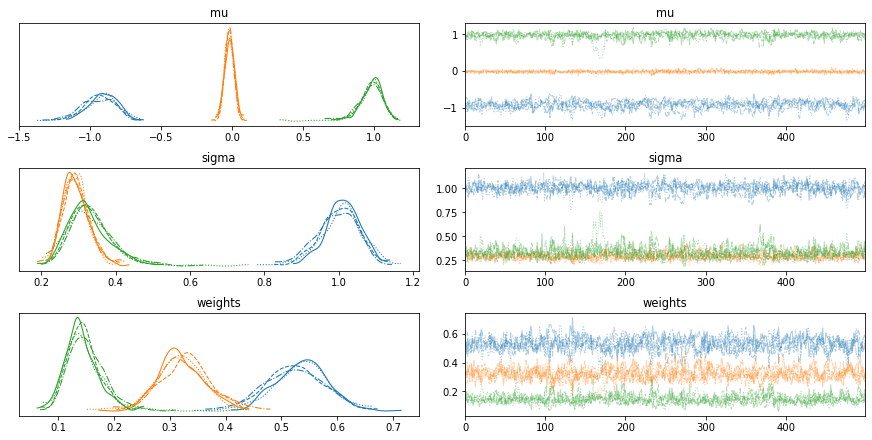

<IPython.core.display.Javascript object>

In [59]:
az.plot_trace(samples)
plt.show()

Below we fix the number of customers, and the hyperparameters.

In [3]:
n = 10
lamb = 10

<IPython.core.display.Javascript object>

$n_k$ is the number of customers for dish $k$, $K$ is the current number of different dishes, $\mathbf{Z}$ is a $(n \times K)$ matrix where every element $z_{ij}$ describes if customer $i$ took dish $k$.

DeviceArray([[0.],
             [0.],
             [0.],
             [0.],
             [0.],
             [0.],
             [0.],
             [0.],
             [0.],
             [0.]], dtype=float32)

<IPython.core.display.Javascript object>

In [93]:
nk = []
K = 0
Z = np.zeros((n, 0))

<IPython.core.display.Javascript object>

Then we generate the dishes using the IBP.

Finally let's plot the binary matrix as tile plot.

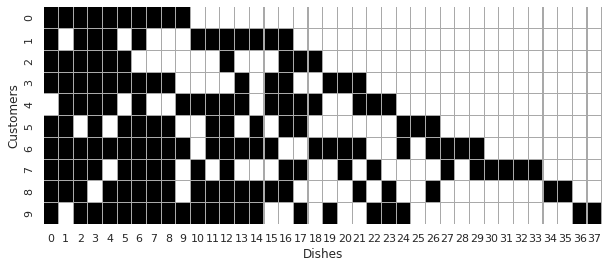

<IPython.core.display.Javascript object>

In [102]:
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    Z,
    linewidths=0.1,
    cbar=False,
    cmap=["white", "black"],
    linecolor="darkgrey",
)
ax.set_xlabel("Dishes")
ax.set_ylabel("Customers")
ax.minorticks_off()
plt.show()

In [104]:
import jax.numpy as np
from numpyro.distributions.util import is_prng_key

<IPython.core.display.Javascript object>

In [106]:
import jax.random as random

<IPython.core.display.Javascript object>

In [107]:
random.PRNGKey(0)

DeviceArray([0, 0], dtype=uint32)

<IPython.core.display.Javascript object>

In [144]:
random.poisson(random.PRNGKey(233), nk[k] / (i + 1) * 22)

Buffer(5, dtype=int32)

<IPython.core.display.Javascript object>

In [148]:
import numpy as onp


class IndianBuffetProcess(dist.Distribution):
    def __init__(self, n, theta):
        super(IndianBuffetProcess, self).__init__(event_shape=(1,))
        self.n = n
        self.theta = theta

    def sample(self, key, sample_shape=()):
        assert is_prng_key(key)
        nk, K = [], 0
        Z = onp.zeros((n, 0), dtype=np.int32)
        for i in range(self.n):
            for k in range(K):
                key, subkey = random.split(key)
                Z[i, k] = random.bernoulli(subkey, nk[k] / (i + 1))
                nk[k] += 1
            key, subkey = random.split(key)
            n_new = random.poisson(random.PRNGKey(233), self.theta / (i + 1))
            z = onp.zeros((n, n_new))
            z[i, :] = 1
            Z = onp.hstack([Z, z])

            nk += list(onp.ones(n_new))
            K += n_new
        return Z

<IPython.core.display.Javascript object>

In [157]:
Z = IndianBuffetProcess(10, 10).sample(random.PRNGKey(23))

<IPython.core.display.Javascript object>

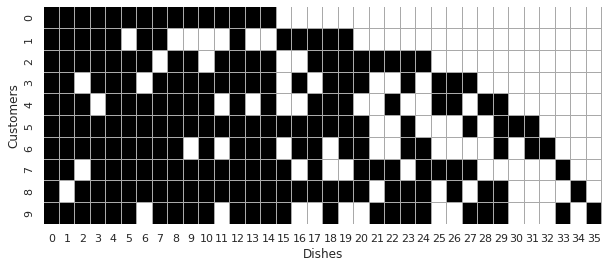

<IPython.core.display.Javascript object>

In [158]:
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    Z,
    linewidths=0.1,
    cbar=False,
    cmap=["white", "black"],
    linecolor="darkgrey",
)
ax.set_xlabel("Dishes")
ax.set_ylabel("Customers")
ax.minorticks_off()
plt.show()